In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
source("./vis.fun.R")

## Use the downsampled data for DEG analysis

## seurat object
hm <- readRDS(file = paste0("./load_files/Human_Macaque_Neuron_slim_addDS_E77.rds"))
Idents(hm) <- "newcls"
DefaultAssay(hm) <- "DS"

## Mean ratios and AVGs for dotplot visualization
load(file = paste0("./load_files/Human_Macaque_Neuron_AVG_DS_E77.Rdata"))


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
##-------------------------------------------------------------------------------
## Identify shared axis-specific features between species
source("./vis.fun.R")

## calculating
allcls <- levels(as.factor(hm$newcls))
allres <- lapply(allcls, function(cls) {
        sp <- extract_field(cls, 1, "|")
        reg <- extract_field(cls, 2, "|")
        subctp <- extract_field(cls, 3, "|")

        bg_cls <- paste0(sp, "|", setdiff(c("FC", "OC"), reg), "|", subctp)
        res <- FindMarkers(hm, ident.1 = cls, ident.2 = bg_cls, max.cells.per.ident = 1000, 
                           only.pos = TRUE, min.pct = 0.1) %>%
                    tibble::rownames_to_column("gene") %>%
                    mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01), 
                           region = reg, cluster = subctp, 
                           species = sp)
        return(res)
        }) %>%
            do.call(rbind, .)

In [3]:
## Extract the genes
top_share <- lapply(c("FC", "OC"), function(reg) {
    top_genes <- lapply(c("ExN deep", "ExN upper"), function(x) {
            genes <- allres %>%
                filter(cluster %in% x & region %in% reg & p_val_adj <= 0.01 & pct.1 >= 0.1 & ratio_fc >= 1.1) %>%
                group_by(gene) %>%
                summarize(nhits = n(), 
                          meanAvgFC = mean(avg_log2FC), 
                          meanRatioFC = mean(ratio_fc), 
                          min.pct.1 = mean(pct.1), 
                          min.pct.2 = mean(pct.2)) %>%
                filter(nhits == 2) %>%
                ungroup() %>%
                arrange(desc(meanRatioFC), desc(meanAvgFC)) %>%
                top_n(., 20, wt = meanRatioFC) %>%
                .$gene
            return(genes)
            }) %>%
            setNames(., c("ExN deep", "ExN upper"))
    return(top_genes)
    }) %>%
    setNames(., c("FC", "OC"))

In [4]:
top_share

$FC
$FC$`ExN deep`
 [1] "PCDH17"  "SULF2"   "IGFBP5"  "CNTNAP2" "LYPD1"   "TMEFF2"  "PCP4"   
 [8] "PPP1R1B" "MGAT4C"  "PCDH10"  "SATB2"   "ROBO1"   "BTG1"    "POU3F2" 
[15] "LMO3"    "ALCAM"   "CYP26A1" "FBXW7"   "NRCAM"   "PCDH11X"

$FC$`ExN upper`
 [1] "VSTM2L"  "CBLN2"   "PCDH17"  "ROBO1"   "CNTNAP2" "NECAB1"  "PLK2"   
 [8] "MASP1"   "TRIM36"  "FSTL5"   "IGFBP5"  "PRSS23"  "LSAMP"   "SCN9A"  
[15] "NNAT"    "SYT4"    "CNTN1"   "SLF1"    "SMARCA2" "HMGCS1" 


$OC
$OC$`ExN deep`
 [1] "LPL"     "WNT7B"   "NR2F1"   "NTRK2"   "TENM2"   "RUNX1T1" "NTM"    
 [8] "SSBP2"   "AGAP1"   "SSBP3"   "AKT3"    "WASF1"   "CRYM"    "SYT4"   
[15] "SOX5"    "NFIX"    "SYT6"    "NELL2"   "TCF4"    "NFIB"   

$OC$`ExN upper`
 [1] "NPY"     "ID2"     "NLGN1"   "MPP6"    "CHMP2B"  "PTPN2"   "NR2F1"  
 [8] "EPHA4"   "BCL11A"  "CAMK2B"  "FAT3"    "CAMK4"   "TENM2"   "FRMD4B" 
[15] "NFIX"    "DOK5"    "ZBTB18"  "FOXG1"   "LUC7L3"  "RUNX1T1"

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 41 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_point()`).”


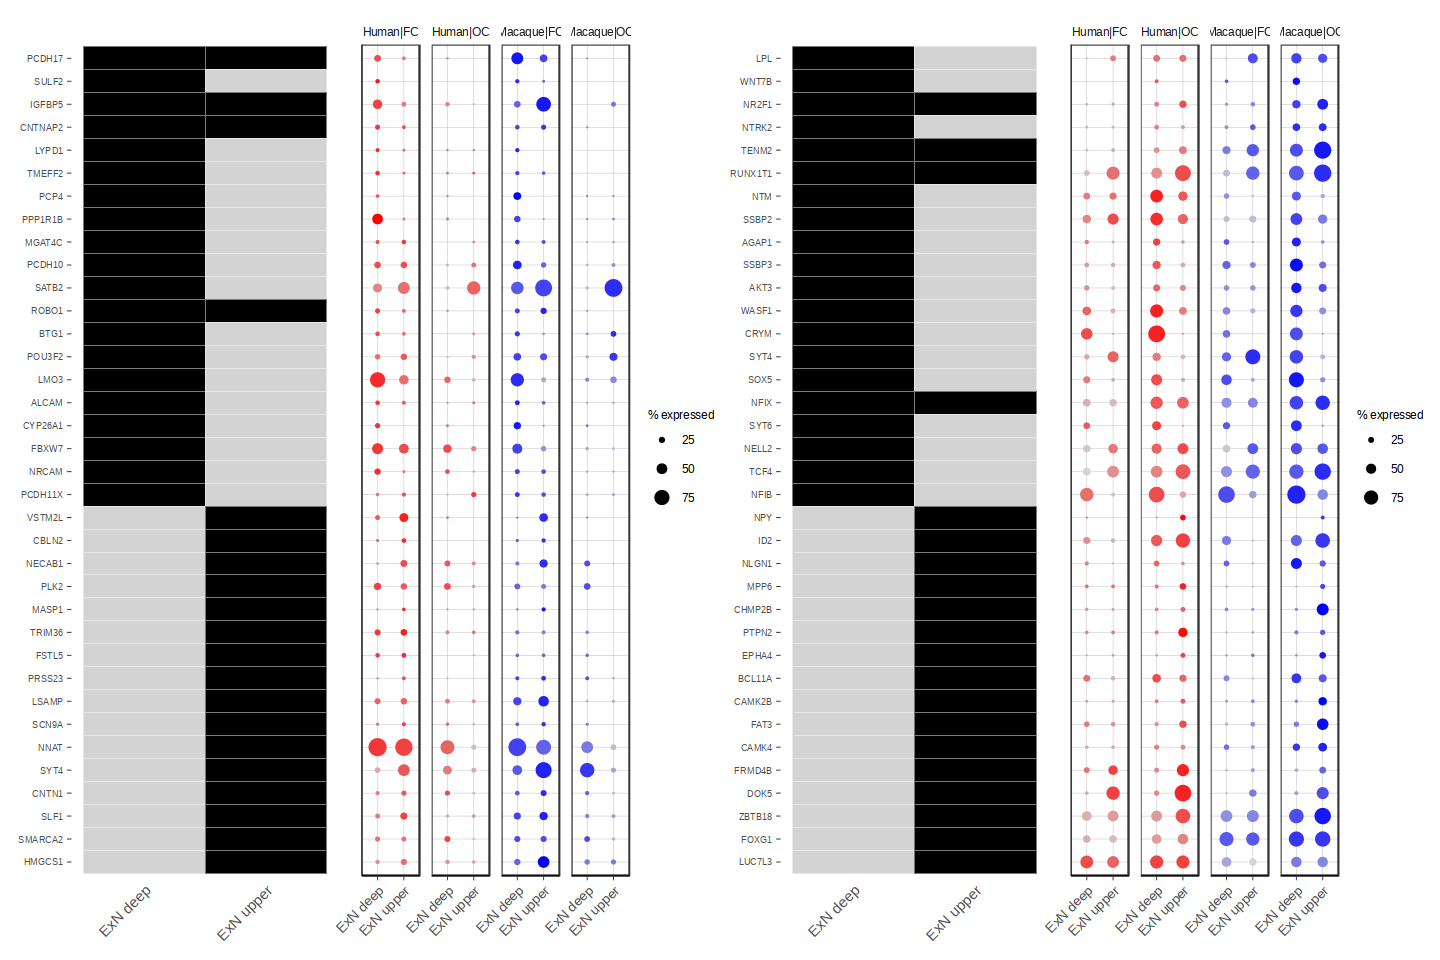

In [5]:
## Visualize the shared AXIS-specific genes
load(file = paste0("./load_files/Human_Macaque_Neuron_AVG_DS_E77.Rdata"))
source("./vis.fun.R")
plist <- lapply(c("FC", "OC"), function(reg){
    p1 <- ExtractDotExpr(avg = avgs, 
                         ratio = ratios, 
                         feature = unique(unlist(top_share[[reg]])), 
                         spcols = c(Human = "red", Macaque = "blue")) %>%
            PlotDot(data.plot = ., dot.scale = 4.5, dot.min = 0.02, font.scale = c(0.9, 0.6)) +
            theme(legend.position = "right", axis.text.y = element_blank(), axis.ticks.y = element_blank())
    p2 <- PlotDEGAnno(dglist = top_share[[reg]])
    pcbn <- patchwork::wrap_plots(list(p2, p1), nrow = 1, ncol = 2, width = c(0.2, 1))
    return(pcbn)
})
pall <- patchwork::wrap_plots(plist, nrow = 1, ncol = 2)
options(repr.plot.width=12, repr.plot.height=8)
pall

In [6]:
pdf(paste0("./report/HM_shared_axis-genes_expr.pdf"), width = 20, height = 6, useDingbats = FALSE)
print(pall)
dev.off()

Warning message:
“Removed 41 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values (`geom_point()`).”


png 
  2

In [7]:
##-------------------------------------------------------------------------------
## Identify species-specific axis-specific features between species
## calculating
dexres <- lapply(allcls, function(cls) {
    sp <- extract_field(cls, 1, "|")
    reg <- extract_field(cls, 2, "|")
    subctp <- extract_field(cls, 3, "|")

    bg_cls <- paste0(setdiff(c("Human", "Macaque"), sp), "|", reg, "|", subctp)
    res <- FindMarkers(hm, ident.1 = cls, ident.2 = bg_cls, 
                       max.cells.per.ident = 1000, 
                       only.pos = TRUE, min.pct = 0.1) %>%
                tibble::rownames_to_column("gene") %>%
                mutate(ratio_fc = (pct.1 + 0.01)/(pct.2 + 0.01), region = reg, cluster = subctp, species = sp)
    return(res)
    }) %>%
        do.call(rbind, .)

In [8]:
degs <- lapply(c("Human", "Macaque"), function(sp){
        bg_sp <- setdiff(c("Human", "Macaque"), sp)
        sp_degs <- lapply(c("FC|ExN deep", "FC|ExN upper", "OC|ExN deep", "OC|ExN upper"), function(x) {
            
            sp_axis <- allres %>%
                        mutate(reg_cls = paste0(region, "|", cluster)) %>%
                        filter(reg_cls %in% x & p_val_adj <= 0.01 & pct.1 >= 0.1 & ratio_fc >= 1.1) %>%
                        group_by(gene) %>%
                        summarize(nhits = n(), 
                                  meanAvgFC = mean(avg_log2FC), 
                                  meanRatioFC = mean(ratio_fc), 
                                  min.pct.1 = mean(pct.1), 
                                  min.pct.2 = mean(pct.2), 
                                  species = paste(species, collapse = ",")) %>%
                        filter(nhits == 1 & species %in% sp) %>%
                        ungroup() %>%
                        arrange(desc(meanRatioFC), desc(meanAvgFC))# %>%
                        ##.$gene
            cls_degs <- dexres %>%
                        filter(gene %in% sp_axis$gene) %>%
                        mutate(reg_cls = paste0(region, "|", cluster)) %>%
                        filter(species %in% sp & reg_cls %in% x & p_val_adj <= 0.01 & 
                               pct.1 >= 0.1 & pct.2 < 0.1 & ratio_fc >= 1.5) %>%
                        mutate(axis_mrFC = sp_axis$meanRatioFC[match(gene, sp_axis$gene)]) %>%
                        mutate(axis_maFC = sp_axis$meanAvgFC[match(gene, sp_axis$gene)]) %>%
                        arrange(desc(round(avg_log2FC, digits = 1)), desc(round(axis_mrFC, digits = 1))) %>%
                        top_n(., 15, wt = avg_log2FC) %>%
                        .$gene
            return(cls_degs)
            }) %>%
            setNames(., c("FC|ExN deep", "FC|ExN upper", "OC|ExN deep", "OC|ExN upper"))
        return(sp_degs)
        }) %>%
        setNames(., c("Human", "Macaque"))

In [9]:
degs

$Human
$Human$`FC|ExN deep`
 [1] "RBP1"    "JUN"     "ENC1"    "BEX5"    "CAMK2N1" "KCNJ6"   "CTNNBL1"
 [8] "DRAXIN"  "SLN"     "GABPB1"  "SCUBE1" 

$Human$`FC|ExN upper`
 [1] "SLN"     "BEX5"    "DRAXIN"  "CCBE1"   "HSPA1A"  "DBI"     "CPE"    
 [8] "MAP3K13" "SCD"     "INAFM1"  "RALYL"   "NLRP1"   "KLHL14"  "GAREM1" 
[15] "PHF20L1"

$Human$`OC|ExN deep`
 [1] "PPIA"    "SLC38A1" "BNIP3L"  "GNAL"    "VSNL1"   "NEFL"    "SPECC1" 
 [8] "CES4A"   "ETV1"    "ASAH1"   "TSTD1"   "KALRN"   "ANKS1B"  "NPM2"   
[15] "CSAD"   

$Human$`OC|ExN upper`
 [1] "NEFL"    "ARFGEF3" "PPFIBP1" "HPCA"    "ASAH1"   "PRKCB"   "CEP135" 
 [8] "CSAD"    "RIC3"    "WFDC2"   "TMEM206" "CAMK2G"  "TIAM2"   "USP1"   


$Macaque
$Macaque$`FC|ExN deep`
 [1] "TMSB15B" "SYNPR"   "CPLX2"   "SYN3"    "CRIM1"   "ECI1"    "GDF1"   
 [8] "NEURL1"  "TSHZ2"   "PLCXD2"  "SLC9A6"  "GAB2"    "TRIM54"  "PTPRN2" 
[15] "SH3RF3" 

$Macaque$`FC|ExN upper`
 [1] "TMEFF1"  "ISLR2"   "FABP3"   "NEUROD1" "GRM5"    "CHCHD10" "PLCXD2" 
 [8] "ZNF704"  "CAV1"    "FLYWCH2" "POSTN"   "DPP10"   "HPCA"    "GDF1"   
[15] "MAST1"  

$Macaque$`OC|ExN deep`
 [1] "IGFBP2"  "SIPA1L2" "NPTX1"   "C1QTNF4" "GLRA1"   "KIF26B"  "H2AFJ"  
 [8] "SIAH3"   "THBS1"   "FHL2"    "KLHL32"  "ST8SIA1" "CHST15" 

$Macaque$`OC|ExN upper`
[1] "IGFBPL1" "CUX2"    "TRIB2"   "BTG1"    "PCDH7"

Warning message:
“Removed 158 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 189 rows containing missing values (`geom_point()`).”


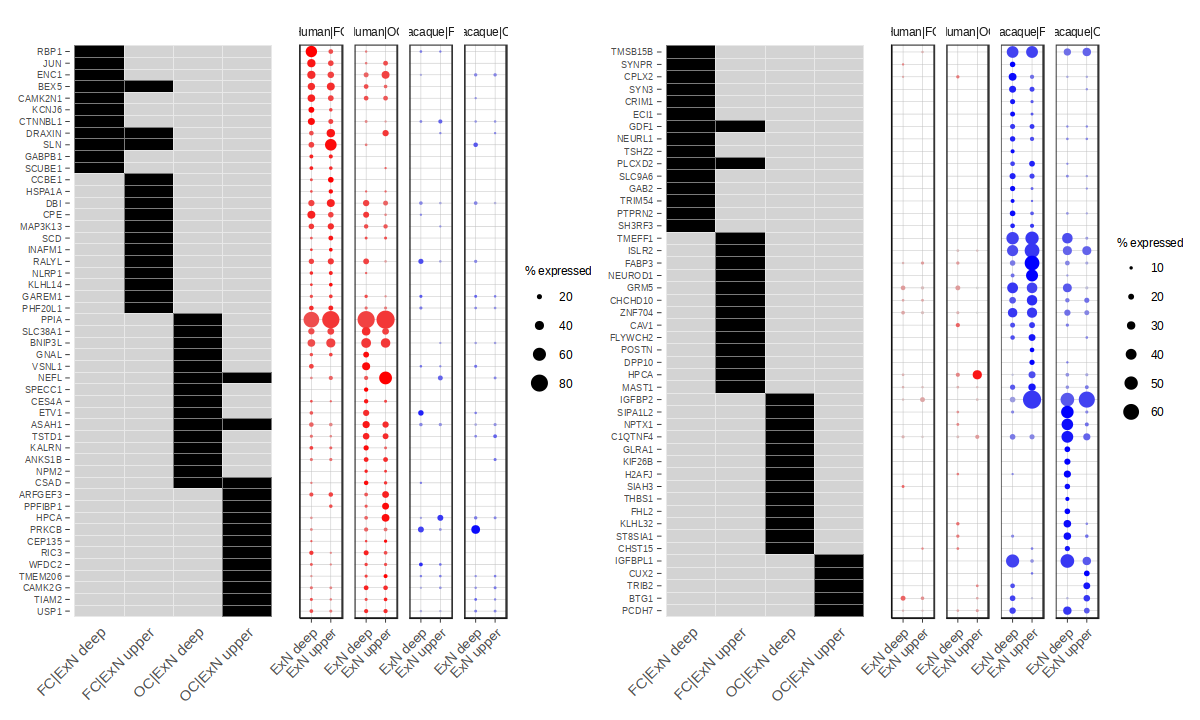

In [10]:
## Visualize 
plist <- lapply(c("Human", "Macaque"), function(sp){
    p1 <- ExtractDotExpr(avg = avgs, ratio = ratios, 
                         feature = unique(unlist(degs[[sp]])), 
                         spcols = c(Human = "red", Macaque = "blue")) %>%
            PlotDot(data.plot = ., dot.scale = 4.5, dot.min = 0.05, font.scale = c(0.9, 0.6)) +
            theme(legend.position = "right", axis.text.y = element_blank(), axis.ticks.y = element_blank())
    p2 <- PlotDEGAnno(dglist = degs[[sp]])
    pcbn <- patchwork::wrap_plots(list(p2, p1), nrow = 1, ncol = 2, width = c(0.2, 1))
    return(pcbn)
})
pall <- patchwork::wrap_plots(plist, nrow = 1, ncol = 2)
options(repr.plot.width=10, repr.plot.height=6)
pall

In [11]:
pdf(paste0("./report/HM_Enriched_axis-genes_expr.pdf"), width = 10, height = 6, useDingbats = FALSE)
print(pall)
dev.off()

Warning message:
“Removed 158 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 189 rows containing missing values (`geom_point()`).”


png 
  2

In [12]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-4.1.0/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.0      dplyr_1.0.10       SeuratObject_4.1.3 Seurat_4.3.0      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.0-3       deldir_1.0-6   